In [1]:
# code up SIRD model with deaths
# fit using adjoint method
# see how well it does on simulated data
# see how well it does on real data
# might have to play with noise parameter

!pip install jaxlib
!pip install jax

  Using cached jaxlib-0.1.51-cp38-none-manylinux2010_x86_64.whl (32.6 MB)
Processing /home/jovyan/.cache/pip/wheels/1d/10/8e/2f79b924179ff1e6510933d63eb851bea01054fff262343b7a/absl_py-0.9.0-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/c1/95/8e/f40e9bcab8ddbae34c8587e1188b68b265e77714e8fb6426eb/jax-0.1.72-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)


In [124]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.nn
from jax import grad, jit, jacobian, random, vmap, lax
from jax.ops import index, index_update
from jax.experimental import ode

from sklearn import linear_model

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as onp

In [4]:
# fname = 'us-counties.csv'
# i = 0
# with open(fname, 'r') as in_file:
#     stripped = (line.strip() for line in in_file)
#     lines = (line.split(",") for line in stripped if 'Alameda' in line)
#     realdat = onp.array([list(map(int, (ln[4:]))) for ln in lines])
    
# print(realdat.shape)

In [5]:
def getnumrec(fname, ind):
    with open(fname, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        line = list(line.split(",") for line in stripped if line)[ind]
        return(onp.array(list(map(int, line[4:]))))

getnumrec('time_series_covid19_confirmed_global.csv', 227-1)

array([      1,       1,       2,       2,       5,       5,       5,
             5,       5,       7,       8,       8,      11,      11,
            11,      11,      11,      11,      11,      11,      12,
            12,      13,      13,      13,      13,      13,      13,
            13,      13,      15,      15,      15,      15,      15,
            15,      16,      16,      24,      30,      53,      73,
           104,     174,     222,     337,     451,     519,     711,
          1109,    1561,    2157,    2870,    2968,    4360,    6141,
          8917,   14157,   19479,   25825,   33761,   43850,   54112,
         66055,   84091,  102276,  122069,  141205,  162707,  188724,
        214205,  244610,  276547,  309699,  337573,  367215,  397992,
        429686,  464442,  497943,  527969,  556522,  581813,  608878,
        637974,  669272,  701996,  730337,  756375,  783716,  809318,
        837422,  871617,  907908,  940829,  968518,  990983, 1015518,
       1043038, 1072

In [63]:
# get line numbers for Indi
lnc = !awk 'BEGIN { FS = "," } ; { print $2 }' time_series_covid19_confirmed_global.csv | grep -n India | awk 'BEGIN {FS = ":"} ; { print $1 }'
lnd = !awk 'BEGIN { FS = "," } ; { print $2 }' time_series_covid19_deaths_global.csv | grep -n India | awk 'BEGIN {FS = ":"} ; { print $1 }'
lnr = !awk 'BEGIN { FS = "," } ; { print $2 }' time_series_covid19_recovered_global.csv | grep -n India | awk 'BEGIN {FS = ":"} ; { print $1 }'
linenos = list(map(int, [lnc[0], lnd[0], lnr[0]]))
print(linenos)

[133, 133, 127]


In [64]:
# get the numeric data corresponding to India's line numbers in each file
globc = getnumrec('time_series_covid19_confirmed_global.csv',linenos[0]-1)
globd = getnumrec('time_series_covid19_deaths_global.csv',linenos[1]-1)
globr = getnumrec('time_series_covid19_recovered_global.csv',linenos[2]-1)

In [77]:
# check that everybody has the same lenth
print(len(globc))
print(len(globd))
print(len(globr))

# population of India
nn = 1.353e9

# put everything together
realdat = onp.vstack([ globc, globr, globd ]).T

# start time when there is >= 1 recorded death
si = 49
realdat = realdat[si:,:]
print(realdat[0,:])
print(realdat.shape)

178
178
178
[62  4  1]
(129, 3)


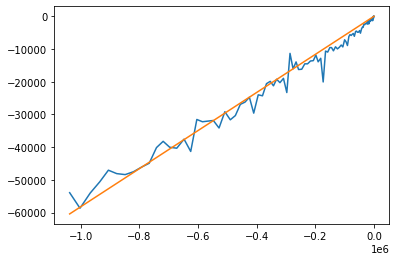

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.8861
Model:                       QuantReg   Bandwidth:                       968.9
Method:                 Least Squares   Sparsity:                        3126.
Date:                Tue, 21 Jul 2020   No. Observations:                  129
Time:                        19:54:14   Df Residuals:                      128
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0582      0.000    149.011      0.000       0.057       0.059


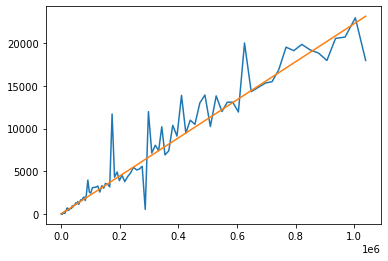

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.8616
Model:                       QuantReg   Bandwidth:                       231.4
Method:                 Least Squares   Sparsity:                        640.9
Date:                Tue, 21 Jul 2020   No. Observations:                  129
Time:                        19:54:14   Df Residuals:                      128
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0223   7.99e-05    279.244      0.000       0.022       0.022


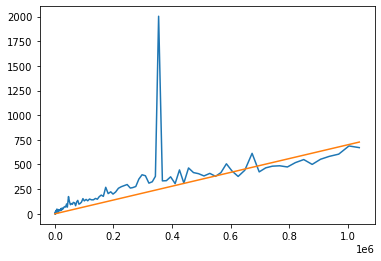

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.6126
Model:                       QuantReg   Bandwidth:                       48.37
Method:                 Least Squares   Sparsity:                        168.2
Date:                Tue, 21 Jul 2020   No. Observations:                  129
Time:                        19:54:14   Df Residuals:                      128
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007    2.1e-05     35.509      0.000       0.001       0.001


In [109]:
globs = nn - (globc + globr + globd)
y = onp.diff(globs)
x = -globc*globs/nn
plt.plot(x[si:],y[(si-1):])
plt.plot(x[si:],0.0582*x[si:])
plt.show()

theta0 = onp.zeros(3)

import statsmodels.api as sm

y = y[(si-1):]
X = x[si:]

results = sm.regression.quantile_regression.QuantReg(y, X).fit(q=.5)
theta0[0] = results.params[0]
print(results.summary())

y = onp.diff(globr)[(si-1):]
X = globc[si:]

plt.plot(X, y)
plt.plot(X, 0.0223*X)
plt.show()

results = sm.regression.quantile_regression.QuantReg(y, X).fit(q=.5)
theta0[1] = results.params[0]
print(results.summary())

y = onp.diff(globd)[(si-1):]
plt.plot(X, y)
plt.plot(X, 0.0007*X)
plt.show()

results = sm.regression.quantile_regression.QuantReg(y, X).fit(q=.5)
theta0[2] = results.params[0]
print(results.summary())

theta0 = onp.log(theta0)

In [89]:
nn

1353000000.0

In [90]:
npts = realdat.shape[0]
n = npts
lentheta = 3
d = 3
dt = 1.0
tint = np.arange(n)*dt

In [91]:
# theta = (beta, gamma, mu)
def sird(x, t, theta):
    s = nn - (x[0] + x[1] + x[2])
    stheta = np.exp(theta)
    idot = stheta[0]*s*x[0]/nn - stheta[1]*x[0] - stheta[2]*x[0]
    rdot = stheta[1]*x[0]
    ddot = stheta[2]*x[0]
    return np.array([idot, rdot, ddot])

In [92]:
# just-in-time (JIT) compiled version
fsird = jit(sird)

# use automatic differentiation and JIT together
mygradsird = jacobian(sird, 0)
fmygradsird = jit(mygradsird)

# use automatic differentiation and JIT together
mygradsirdtheta = jacobian(sird, 2)
fmygradsirdtheta = jit(mygradsirdtheta)


In [100]:
xinit = 200.0*realdat[0,:]
x = lax.stop_gradient(ode.odeint(lambda y, t: fsird(y, t, theta0), t=tint, rtol=1e-9, atol=1e-9, y0=xinit)).T

In [101]:
print(x[2,-1], realdat[-1,2])


23395.37738438879 26273


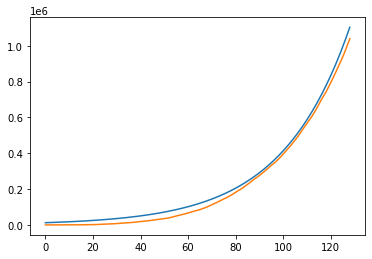

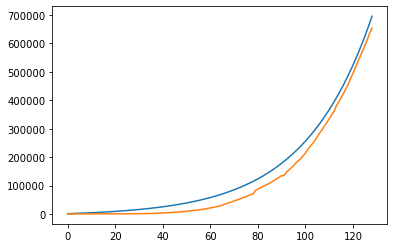

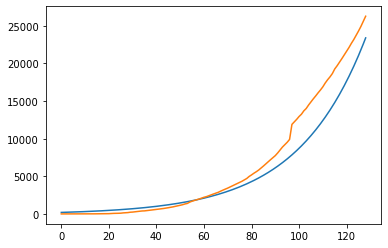

In [102]:
for i in range(3):
    plt.plot(x[i,:])
    plt.plot(realdat[:,i])
    plt.show()


In [103]:
# for scipy.optimize
# z should have (xinit, curtheta)
# note that the t variable is **not** passed in as z[0]
def newlagwithgrad(xinit, curtheta):
    # solves the forward ODE using our current estimates of xinit and curtheta
    fsirdI = lambda y, t: fsird(y, t, curtheta)
    x = lax.stop_gradient(ode.odeint(fsirdI, t=tint, rtol=1e-9, atol=1e-9, y0=xinit)).T
    
    # set up adjoint ODE
    fadj = lambda y, t: -np.matmul(y, fmygradsird(y, t, curtheta))
    icmat = np.eye(d)
    adjtint = np.array([0, dt])
    
    # function that solves the adjoint ODE once for one initial condition
    @jit
    def solonce(y0):
        adjsol = lax.stop_gradient(ode.odeint(fadj, t=adjtint, rtol=1e-9, atol=1e-9, y0=y0))
        return adjsol[1,:]
    
    # this is to solve the adjoint ODE for all initial conditions in the icmat **at once**
    propagator = vmap(solonce, in_axes=(0))(icmat) # + (1e-6)*np.eye(d)
    backprop = lax.stop_gradient(np.linalg.inv(propagator))

    yminusx = lax.stop_gradient(y - x)
    
    @jit
    def growlamb(i, lamb):
        lambplus = np.matmul(lamb[i,:], backprop)
        outlamb = index_update(lamb, index[i+1, :], lambplus + yminusx[:,(npts-2-i)])
        return outlamb
        
    initlamb = np.vstack([np.expand_dims(yminusx[:,(npts-1)],0), np.zeros((npts-1, d))])
    lambminus = lax.fori_loop(0, npts-1, growlamb, initlamb)
            
    # compute current value of lagrangian
    allxdot = np.hstack([(x[:,[1]]-x[:,[0]]), (x[:,2:] - x[:,:-2])/2, (x[:,[npts-2]]-x[:,[npts-3]])])/dt
    
    @jit
    def goodfun(i, lag):
        f = fsird(x[:, i], tint[i], curtheta)
        lag1 = lag + np.dot(lambminus[npts-1-i], allxdot[:,i]-f)*dt
        return lag1
        
    lag = lax.fori_loop(0, npts-1, goodfun, 0.0)
    lag += np.sum(np.square(x - y))/2.0
    
    # compute gradients using lamb (solution of adjoint ODE)
    # gradient of L with respect to parameters theta
    initgradtheta = np.zeros(lentheta)
    
    @jit
    def gt1i(i, gt):
        g = fmygradsirdtheta(x[:, i], tint[i], curtheta).reshape((d, lentheta))  # nabla_theta f
        gradtheta = gt - np.matmul(lambminus[npts-1-i],g)*dt
        return gradtheta
    
    gradtheta = lax.fori_loop(0, npts-1, gt1i, initgradtheta)
    gradx0 = -lambminus[npts-2]
    
    return lag, gradx0, gradtheta, x

In [104]:
lagwithgrad = jit(newlagwithgrad)

In [119]:
# adjoint solver with GD (gradient descent)
y = 1.0*realdat.T

# take as initial guess x = y
# theta0 = onp.log(onp.array([0.0564, 0.0227, 0.008]))
x0 = 200*y[:,0] # + onp.random.normal(size=d)
print(x0)

maxiters = 19001
step = 5e-12

x = x0.copy()
theta = theta0.copy()

lag, gradx0, gradtheta, xest = lagwithgrad(x, theta)
print(onp.linalg.norm(gradtheta))
print(onp.linalg.norm(gradx0))

# mys = 1e-2
for i in range(maxiters):
    lag, gradx0, gradtheta, xest = lagwithgrad(x, theta)
    if i % 1000 == 0:
        mse = np.mean(np.square(xest - realdat.T), axis=1)
        print(lag, onp.exp(theta), x, mse)

    gradtheta /= 10000
    gradx0 /= 100
    theta -= step*gradtheta
    x -= step*gradx0



[12400.   800.   200.]
9808047282083.398
130570508.12600498
112881928931.28844 [0.05815151 0.02232508 0.00074519] [12400.   800.   200.] [8.45962975e+08 9.35857223e+08 4.62216940e+06]
62175438049.59304 [0.05650742 0.02112834 0.00074629] [12399.99930818   799.99989135   200.00000843] [4.65858509e+08 4.93914633e+08 5.81100128e+06]
62073837811.98835 [0.05638794 0.02099665 0.00074713] [12399.99876145   799.99980016   200.00001673] [4.66811975e+08 4.91252162e+08 5.74046994e+06]
62072047239.37429 [0.0563752  0.02098182 0.00074795] [12399.99822903   799.99971088   200.00002498] [4.66945620e+08 4.91107963e+08 5.70033655e+06]
62069924347.55815 [0.05637447 0.02098014 0.00074876] [12399.99769823   799.99962181   200.00003319] [4.66960905e+08 4.91093767e+08 5.66375671e+06]
62067625635.32312 [0.05637511 0.02097995 0.00074958] [12399.99716761   799.99953277   200.00004137] [4.66962413e+08 4.91092366e+08 5.62774594e+06]
62065315732.45095 [0.05637591 0.02097993 0.00075039] [12399.996637     799.999443

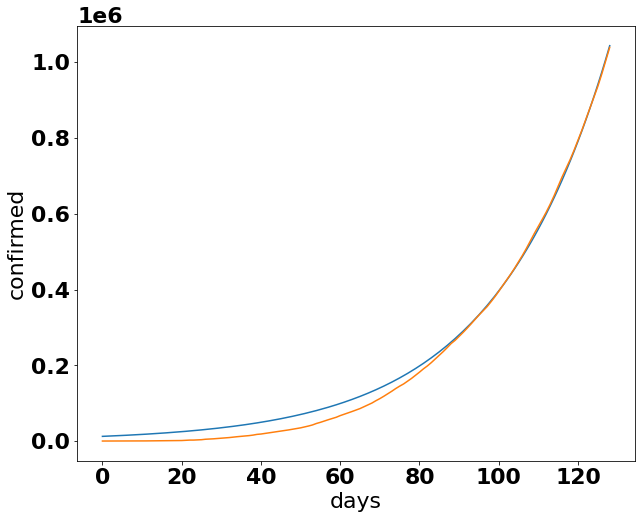

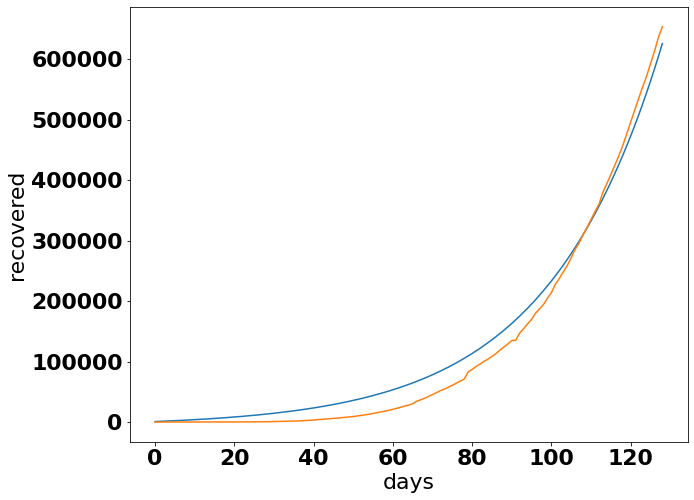

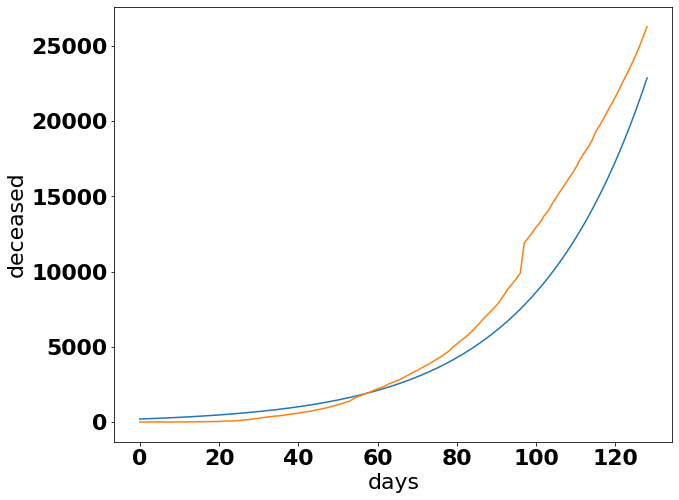

In [130]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

myxlab = 'days'
myylab = ['confirmed','recovered','deceased']
for i in range(3):
    plt.figure(figsize=(10,8))
    plt.plot(xest[i])
    plt.plot(realdat[:,i])
    plt.xlabel(myxlab)
    plt.ylabel(myylab[i])
    plt.show()

In [117]:
thetareal = onp.exp(theta)

In [118]:
r0 = thetareal[0]/(thetareal[1]+thetareal[2])
print(r0)

2.59416389698005
